In [6]:
disable_warnings = True
if disable_warnings:
    import warnings
    warnings.filterwarnings('ignore')

import pickle
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns

from utils.model_utils import ExtendedLanguageModel
from utils.data_utils import AnalogiesDataLoader
from utils.plot_utils import plot_RDM_concept
from utils.eval_utils import get_RDM, get_unique_indices, get_rule_sim_diagonal

from __future__ import print_function
from ipywidgets import interactive


DATA_DIR = 'data/ICL/results'

In [3]:
# Select Model
model_widget = interactive(lambda model_name: model_name,
                      model_name=[
                            'meta-llama/Llama-2-70b-hf',
                            'EleutherAI/gpt-j-6b'
                      ])
display(model_widget)

interactive(children=(Dropdown(description='model_name', options=('meta-llama/Llama-2-70b-hf', 'EleutherAI/gpt…

In [4]:
model_name = model_widget.children[0].value
model = ExtendedLanguageModel(model_name)
print(f"Selected model: {model_name}\n")

Selected model: meta-llama/Llama-2-70b-hf



In [7]:
results_path = f'{DATA_DIR}/{model.nickname}__{5}_n.pkl'
data = pickle.load(open(results_path, 'rb'))

In [20]:
FVs = np.concatenate([data[dataset]['FVs'] for dataset in data.keys()])


In [19]:
FVs

(1000, 8192)

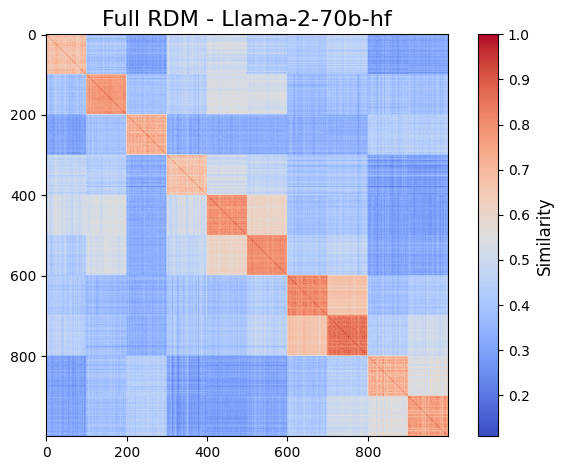

In [21]:
full_rdm = get_RDM(FVs)

plot_RDM_concept(full_rdm, title=f'Full RDM - {model.nickname}', rel_ticks=False)